In [12]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, BatchNormalization,Concatenate
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_curve, auc,ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import tensorflow_hub as hub

from tensorflow.keras import datasets, layers, models

import kagglehub

In [5]:
path = kagglehub.dataset_download("feyzazkefe/trashnet")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/trashnet


In [7]:
DATASET_PATH ='/kaggle/input/trashnet/dataset-resized'

In [8]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 30
LEARNING_RATE = 0.001

image_paths = []
labels = []

for class_name in sorted(os.listdir(DATASET_PATH)):
    class_dir = os.path.join(DATASET_PATH, class_name)
    if os.path.isdir(class_dir):
        for img in os.listdir(class_dir):
            image_paths.append(os.path.join(class_dir, img))
            labels.append(class_name)

df = pd.DataFrame({'filename': image_paths, 'class': labels})

# Split dataset into 70% Train, 10% Validation, 20% Test
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=2/3, stratify=temp_df['class'], random_state=42)

print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

Train: 1768, Validation: 253, Test: 506


In [9]:
# Compute global mean and std for normalization
def compute_mean_std(df):
    mean = np.zeros(3)
    std = np.zeros(3)
    num_samples = 0

    for img_path in df['filename']:
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
        img = np.array(img) / 255.0
        mean += np.mean(img, axis=(0, 1))
        std += np.std(img, axis=(0, 1))
        num_samples += 1

    mean /= num_samples
    std /= num_samples
    return mean, std

global_mean, global_std = compute_mean_std(train_df)
print(f"Global Mean: {global_mean}, Global Std: {global_std}")

Global Mean: [0.67278962 0.6398155  0.60588654], Global Std: [0.1842642  0.18333925 0.19366157]


In [11]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)
train_datagen.mean = global_mean
train_datagen.std = global_std

# Only normalization for validation and testing
test_val_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    featurewise_center=True,
    featurewise_std_normalization=True
)
test_val_datagen.mean = global_mean
test_val_datagen.std = global_std

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = test_val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_val_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1768 validated image filenames belonging to 6 classes.
Found 253 validated image filenames belonging to 6 classes.
Found 506 validated image filenames belonging to 6 classes.


In [14]:
efficientnet_lite = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2",
    trainable=False  # Set True if you want to fine-tune
)

input_tensor = Input(shape=(224, 224, 3))
efnet_out = Lambda(lambda x: efficientnet_lite(x))(input_tensor)
x = Dropout(0.5)(efnet_out)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
num_classes = len(train_generator.class_indices)  # Get number of classes
out = Dense(num_classes, activation='softmax')(x)

# Create Hybrid Model
model = Model(inputs=input_tensor, outputs=out)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7,verbose = 1)

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 658,950 (2.51 MB)

 Trainable params: 658,950 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=EPOCHS,
                        steps_per_epoch=len(train_generator)//BATCH_SIZE,
                        validation_steps=len(val_generator)//BATCH_SIZE,
                        callbacks=[lr_scheduler])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.3651 - loss: 1.7312 - val_accuracy: 0.6403 - val_loss: 0.8818 - learning_rate: 0.0010
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.6298 - loss: 0.9767 - val_accuracy: 0.6957 - val_loss: 0.7297 - learning_rate: 0.0010
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.6881 - loss: 0.8461 - val_accuracy: 0.7273 - val_loss: 0.6500 - learning_rate: 0.0010
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.7036 - loss: 0.7947 - val_accuracy: 0.7787 - val_loss: 0.6318 - learning_rate: 0.0010
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.7338 - loss: 0.7041 - val_accuracy: 0.7668 - val_loss: 0.6347 - learning_rate: 0.0010
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.7462 - loss: 0.6785 - val_accuracy: 0.7787 - val_loss: 0.5877 - learning_rate: 0.0010
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.7295 - loss: 0.7145 - val_accuracy: 

In [ ]:
# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("hybrid_model_trashnet.tflite", "wb") as f:
    f.write(tflite_model)
print("Model converted to TensorFlow Lite!")

In [16]:
# Evaluate Model
#with tf.device('/GPU:0'):
test_loss, test_accuracy = model.evaluate(test_generator)

# Generate Predictions
#with tf.device('/GPU:0'):
predictions = model.predict(test_generator)

# Convert Predictions to Class Labels
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes  # Get true labels

# Calculate Evaluation Metrics
precision = precision_score(y_true, y_pred, average='macro')
sensitivity = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Confusion Matrix & Specificity Calculation
cm = confusion_matrix(y_true, y_pred)
specificity_list = []
for i in range(cm.shape[0]):  # Loop through each class
    TN = cm.sum() - (cm.sum(axis=0)[i] + cm.sum(axis=1)[i] - cm[i, i])  # True Negatives
    FP = cm.sum(axis=0)[i] - cm[i, i]  # False Positives
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # Avoid division by zero
    specificity_list.append(specificity)
average_specificity = np.mean(specificity_list)

# Cohen's Kappa Score
kappa = cohen_kappa_score(y_true, y_pred)

# Print Metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"F1 Score: {f1:.4f}")
for i, spec in enumerate(specificity_list):
    print(f"Class {i}: Specificity: {spec:.4f}")
print(f"Average Specificity: {average_specificity:.4f}")
print(f"Cohen's Kappa Score: {kappa:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.8318 - loss: 0.4889
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step
Test Accuracy: 0.8241
Precision: 0.8055
Sensitivity (Recall): 0.8026
F1 Score: 0.8034
Class 0: Specificity: 0.9694
Class 1: Specificity: 0.9754
Class 2: Specificity: 0.9552
Class 3: Specificity: 0.9561
Class 4: Specificity: 0.9462
Class 5: Specificity: 0.9833
Average Specificity: 0.9643
Cohen's Kappa Score: 0.7841


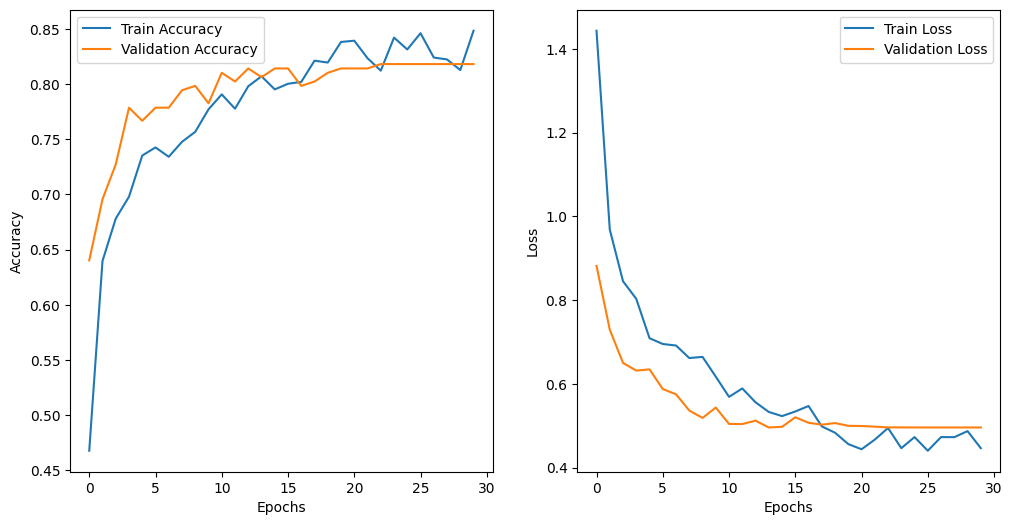

In [17]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

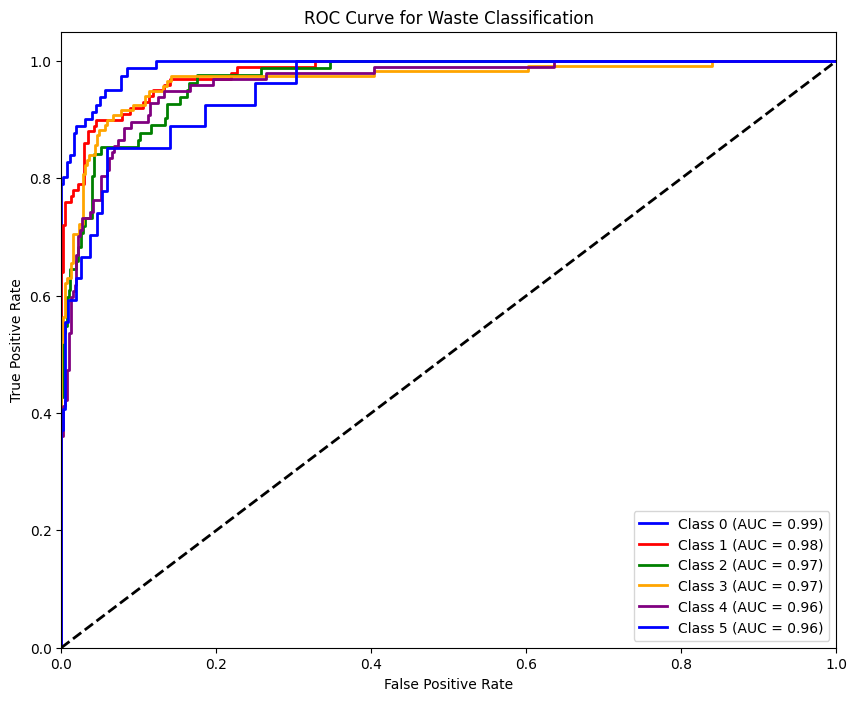

In [18]:
# ROC Curve
y_true_binarized = label_binarize(y_true, classes=np.arange(len(cm)))  # Adjust based on class count
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])

plt.figure(figsize=(10, 8))
for i, color in zip(range(len(cm)), colors):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Waste Classification')
plt.legend(loc="lower right")
plt.show()

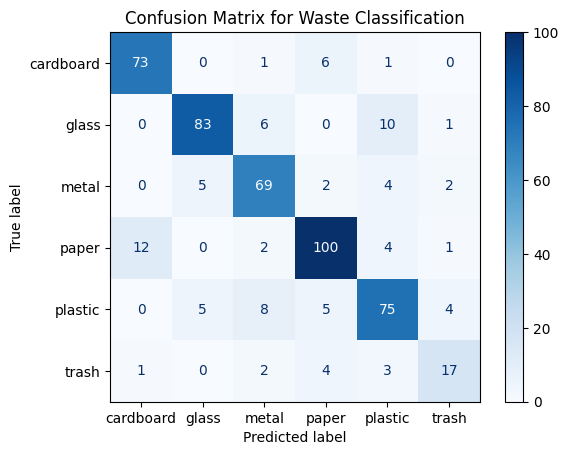

In [19]:
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Waste Classification')
plt.show()